In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
from model import sampling_rnn
import numpy as np
import copy

from helpers import get_sequences, iterate_minibatches, get_minibatches

import matplotlib.pyplot as plt

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

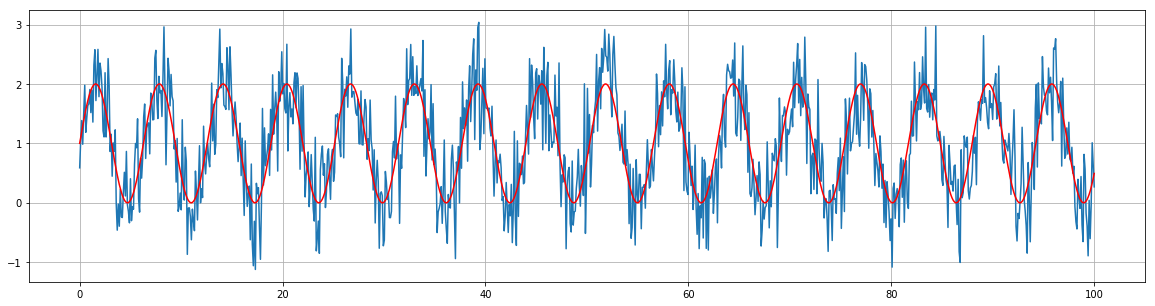

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
# split it to train and test
slice_ind = int(n_samples*0.7)
# clear up namings for modeling
plot_train_x, train_original_x, plot_test_x, test_x, smooth_train_x, smooth_test_x = [x[:slice_ind], y[:slice_ind], 
                                                                             x[slice_ind:], y[slice_ind:], 
                                                                             smooth[:slice_ind], smooth[slice_ind:]]
# # chunk it to each small window
# seq_len = 5
# train_x = get_sequences(train_original_x, seq_len, 1)

In [5]:
# train_x.shape

In [6]:
# test_x.shape

#### So we have observed that the multiple time steps look ahead training, we want to gradually in increase the horizon
first need to figure out how to make the model to take in dynamic sequence length if it's not by default already

In [13]:
%%time
tf.reset_default_graph()

batch_size = 32
state_size = 100

# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input 
h = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, [batch_size, None, 1], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, None, 1], name = 'train_label')

output, last_states = sampling_rnn(cell=lstm_cell, 
                                   initial_state=initial_state, 
                                   input_=X,
                                   batch_size=batch_size,
                                   seq_lengths=h)
# output as the prediction
# pred = tf.reshape(output, (batch_size, seq_len, 1))

print(output.shape)
pred = output
# pred = tf.reshape(output, (batch_size, h, 1))
# pred = tf.reshape(output, (batch_size, h, 1))

print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))
# loss
loss = tf.losses.mean_squared_error(Y, pred)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)

# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
printn = 1e2
horizon = 5
for k in range(1, horizon+1):
    print('Horizon {} ======'.format(k+1))
    # chunk it to each small window
    seq_len = k + 1
    train_x = copy.deepcopy(get_sequences(train_original_x, seq_len, 1))
    for i in range(1000):
        epoch_loss =0.
        for batch in iterate_minibatches(train_x, np.roll(train_x, -1), batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_xi, Y: train_yi, h:seq_len})
            epoch_loss += l

        if i%printn ==0:
            print('Epoch {0:} | loss: {1:.4f}'.format(i, epoch_loss))
    
    
# # save model
# #Create a saver object which will save all the variables
# saver = tf.train.Saver()
# #save the graph
# saver.save(sess, save_path='./models/test_model')

(32, ?, 1)
label shape:(32, ?, 1) | output prediction shape: (32, ?, 1)
Horizon 2 ======
Epoch 0 | loss: 16.5028
Epoch 100 | loss: 4.4731
Epoch 200 | loss: 4.4576
Epoch 300 | loss: 4.4456
Epoch 400 | loss: 4.3929
Epoch 500 | loss: 4.3819
Epoch 600 | loss: 4.3744
Epoch 700 | loss: 4.3715
Epoch 800 | loss: 4.3697
Epoch 900 | loss: 4.3681
Horizon 3 ======
Epoch 0 | loss: 3.4264
Epoch 100 | loss: 2.7851
Epoch 200 | loss: 2.7479
Epoch 300 | loss: 2.7262
Epoch 400 | loss: 2.7112
Epoch 500 | loss: 2.6971
Epoch 600 | loss: 2.6869
Epoch 700 | loss: 2.6802
Epoch 800 | loss: 2.6757
Epoch 900 | loss: 2.6711
Horizon 4 ======
Epoch 0 | loss: 2.5033
Epoch 100 | loss: 2.2590
Epoch 200 | loss: 2.2410
Epoch 300 | loss: 2.2268
Epoch 400 | loss: 2.2162
Epoch 500 | loss: 2.2086
Epoch 600 | loss: 2.2033
Epoch 700 | loss: 2.1998
Epoch 800 | loss: 2.1965
Epoch 900 | loss: 2.1936
Horizon 5 ======
Epoch 0 | loss: 2.0258
Epoch 100 | loss: 1.7431
Epoch 200 | loss: 1.7181
Epoch 300 | loss: 1.7023
Epoch 400 | loss:

#### Test model

In [8]:
# make test set
test_x = get_sequences(test_x, seq_len, 1)
# randomly choose some test segment
# test_ind = np.random.randint(0, test_x.shape[0]-batch_size-1)
test_ind = 0
assert test_ind < test_x.shape[0]-batch_size-1, print('index is out of test set range with length ', len(test_x), test_x.shape[0]-batch_size-1)
ctest_x = test_x[test_ind:test_ind+batch_size, :, :]

In [9]:
# make plot test set
plot_test_x = get_sequences(plot_test_x, seq_len, 1)
plot_ctest_x = plot_test_x[test_ind:test_ind+batch_size, :, :]
plot_ctest_x = plot_ctest_x.reshape(-1)

In [10]:
# test_x, test_y = get_minibatches(test_x, np.roll(test_x, -1), 32)

In [11]:
test_pred = sess.run([output], feed_dict={X: ctest_x, h:seq_len})[0]
test_pred = test_pred.reshape(-1)

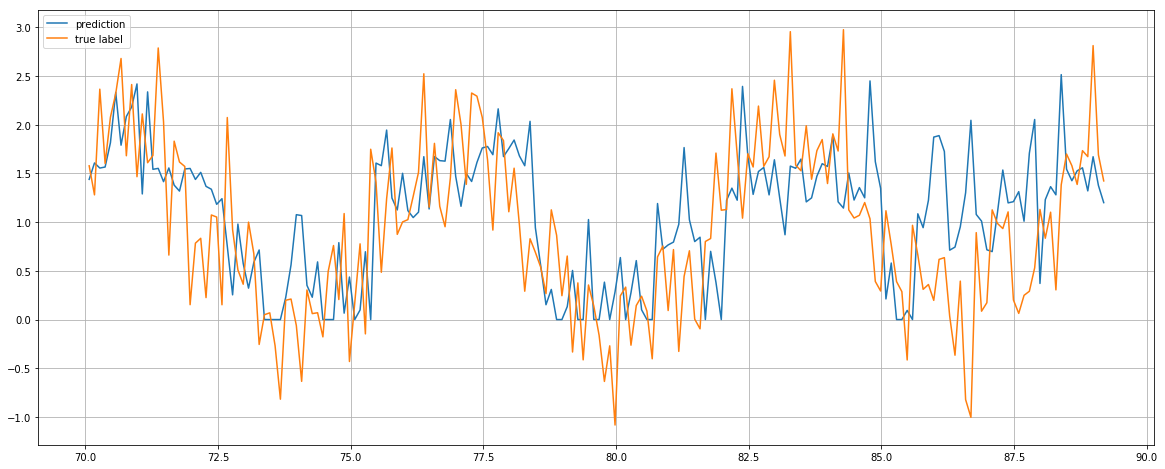

In [12]:
plt.figure(figsize=(20,8))
plt.plot(plot_ctest_x, test_pred, plot_ctest_x, np.roll(ctest_x.reshape(-1), -1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)